In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [2]:
# Default Split
train_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [3]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [4]:
train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    num_workers=8,
    # pin_memory=True,
    # pin_memory_device='cuda'
    # shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=len(test_data),
    num_workers=8,
    # pin_memory=True,
    # pin_memory_device='cuda:0',
    # shuffle=False
)

In [5]:
class MNISTV0(nn.Module):
    def __init__(self) -> None:
        super(MNISTV0, self).__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(32*7*7, 128),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [6]:
model = MNISTV0()
model.to('cuda')

MNISTV0(
  (cnn_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [37]:
len(train_data_loader.dataset)

60000

In [25]:
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    # Train
    model.train()
    for batch_idx, (data, label) in enumerate(train_data_loader):
        data, label = data.to('cuda'), label.to('cuda')
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
    # Test
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        correct = 0
        for data, label in test_data_loader:
            data, label = data.to('cuda'), label.to('cuda')
            output = model(data)
            test_loss += loss_fn(output, label).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
        test_loss /= len(test_data_loader)
    
    print(f'Epoch: {epoch}, Test Loss: {test_loss}, Test Set Accuracy: {correct/len(test_data_loader.dataset)}')
        

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.051316265016794205, Test Set Accuracy: 0.9873
Epoch: 1, Test Loss: 0.05240200087428093, Test Set Accuracy: 0.9873
Epoch: 2, Test Loss: 0.04966003820300102, Test Set Accuracy: 0.9887
Epoch: 3, Test Loss: 0.051405176520347595, Test Set Accuracy: 0.9881
Epoch: 4, Test Loss: 0.04931962117552757, Test Set Accuracy: 0.9886
Epoch: 5, Test Loss: 0.053723059594631195, Test Set Accuracy: 0.9883
Epoch: 6, Test Loss: 0.05040111020207405, Test Set Accuracy: 0.9893
Epoch: 7, Test Loss: 0.06028882414102554, Test Set Accuracy: 0.988
Epoch: 8, Test Loss: 0.07598552852869034, Test Set Accuracy: 0.9868
Epoch: 9, Test Loss: 0.06672943383455276, Test Set Accuracy: 0.9882


In [29]:
torch.save(model, './model/mnist_v0.pth')

In [35]:
test_image = test_data.data[69]
test_image.shape

torch.Size([28, 28])

tensor([0], device='cuda:0')

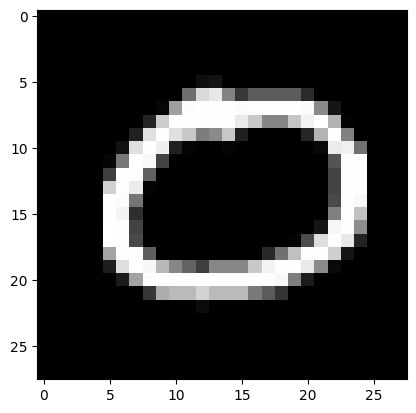

In [36]:
from matplotlib import pyplot as plt

plt.imshow(test_image, cmap='gray')
model_pred = model(test_image.unsqueeze(dim=0).unsqueeze(dim=0).float().to('cuda'))
model_pred.argmax(dim=1)